# Comparing Frogs and Tori #

This code was used for an example application of the normalized bottleneck distance in the paper below.

The paper can be found here: https://link.springer.com/article/10.1007/s44007-024-00130-0

The arXiv link: https://arxiv.org/abs/2306.06727

By applying the normalized bottleneck distance to various sets of point cloud data, we can classify the data-sets based on the homology of the underlying mesh. This is in contrast to the ordinary definition of bottleneck distance, which has difficulty with the various scales of the datasets. 

## Import Libraries ##

Run this cell first.

In [3]:
import numpy as np
import persim
import ripser
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
%matplotlib inline
import umap
import trimesh
import random

2024-09-18 21:16:14.719847: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-18 21:16:14.948093: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 21:16:18.049203: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-18 21:16:18.051516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-09-18 21:16:27.026415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


This code will be used in sampling from 3D models and generating samples.

In [4]:
#For quality of life
def get_var_name(var):
    for name, value in globals().items():
        if value is var:
            return name
        
def diameter(A):
    '''Find the diameter of a data set, A.
    
    inputs:
        A: A data set stored as a np array
    outpus:
        d: The diameter of the dataset'''
    
    D = pdist(A)
    D = squareform(D)
    d = np.nanmax(D)
    
    return d

def sample(mesh,epsilon=0.1,metric='euclidean',samplesize = 100):
    
    vertices = mesh.vertices
    numvertices = len(vertices)
    N = np.zeros(numvertices)
    for i in range(numvertices):
        D = cdist(vertices[i][np.newaxis,:],vertices,metric=metric)
        inrange = D <= epsilon
        N[i] = sum(sum(inrange))
    
    props = 1/N
    props = np.cumsum(props)/sum(props)
    
    selected = []
    
    for i in range(samplesize):
        r = np.random.uniform(0,1,1)
        for j in range(numvertices):
            if r<=props[j] and not props[j] in selected:
                selected.append(j)
                break
    
    selected = vertices[selected,:]
    return selected

def torus(R=1,r=0.5, noisy=True, numsamples = 1000):
    
    scale = np.sqrt(R**2 + r**2) / 100
    
    T = np.zeros((numsamples,3))
    
    for i in range(numsamples):
        theta,phi = 2*np.pi*random.random(),2*np.pi*random.random()
        
        if noisy:
            x,y,z = (R+r*np.cos(theta))*np.cos(phi) + random.random()*scale, (R+r*np.cos(theta))*np.sin(phi) + random.random()*scale, r*np.sin(theta) + random.random()*scale
            
            T[i,0],T[i,1],T[i,2] = x,y,z
        
        else:
            
            x,y,z = (R+r*np.cos(theta))*np.cos(phi), (R+r*np.cos(theta))*np.sin(phi), r*np.sin(theta)
            
            T[i,0],T[i,1],T[i,2] = x,y,z
    
    return T

## Import Data Sets ##

Here are the 3d models we are using for generating data:

Frog 1: https://free3d.com/3d-model/frog-v1--149240.html

Frog 2: https://free3d.com/3d-model/frog-v1--30593.html

Frog 3: https://free3d.com/3d-model/banjofrog-v1--699349.html

Frog 4: https://free3d.com/3d-model/frog-v1--64825.html

Chair 1: https://free3d.com/3d-model/-folding-chair-metal-v2--311510.html

Chair 2: https://free3d.com/3d-model/folding-chairs-v1--612720.html

Chair 3: https://free3d.com/3d-model/fold-out-chair-folded-v1--372704.html

Chair 4: https://free3d.com/3d-model/monobloc-chair-v1--691935.html

unable to load materials from: 12270_Frog_v1_L3.mtl


specified material (Frog)  not loaded!


unable to load materials from: 20436_Frog_v1 textured.mtl


unable to load materials from: 12268_banjofrog_v1_L3.mtl


specified material (12268_banjofrog_)  not loaded!


unable to load materials from: 13772_Frog_new.mtl


specified material (_13772_Frog_V1default)  not loaded!


unable to load materials from: 10227_Folding_Chair_metal_v2_Iterations-2.mtl


specified material (10227_Folding_Chair_metal_v2)  not loaded!


unable to load materials from: 13494_Folding_Chairs_v1_L3.mtl


specified material (13494_Folding_Chairs)  not loaded!


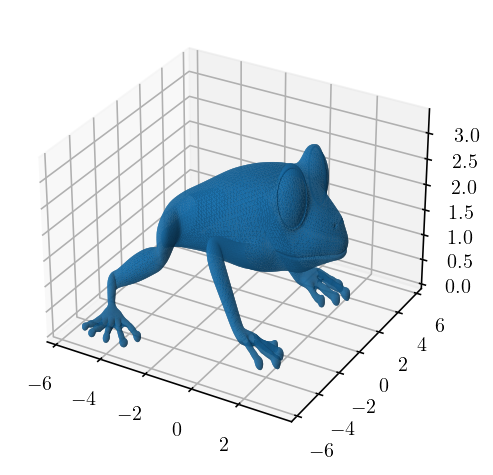

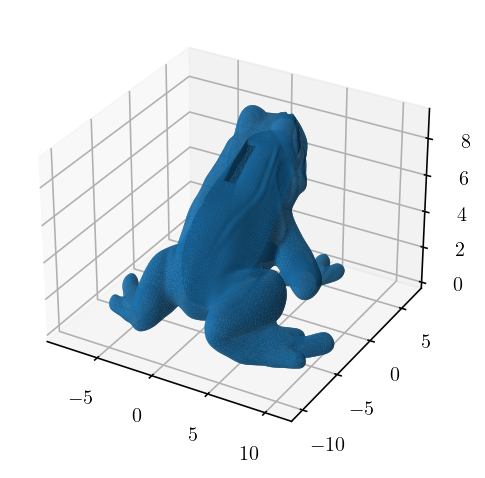

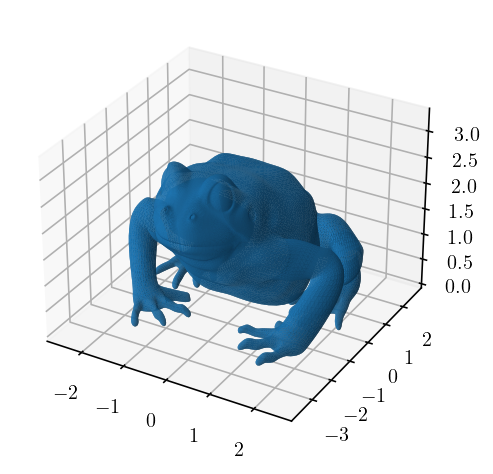

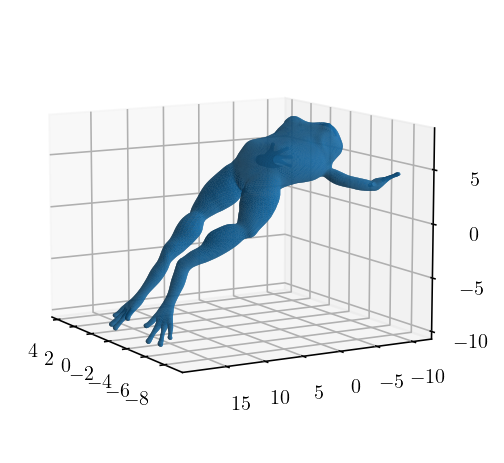

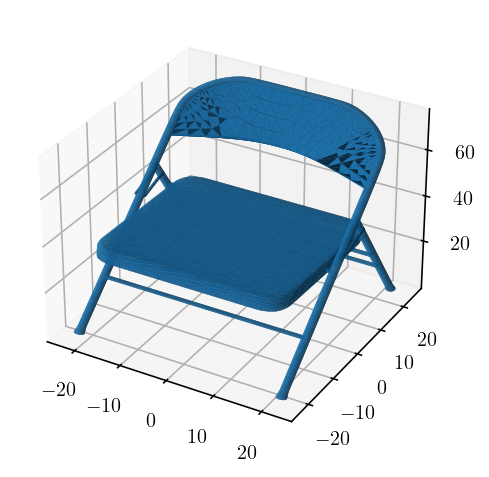

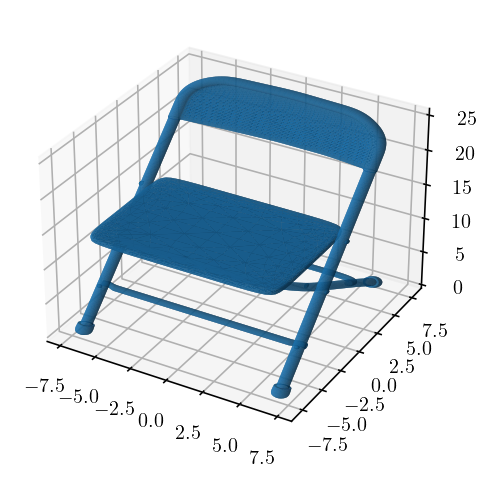

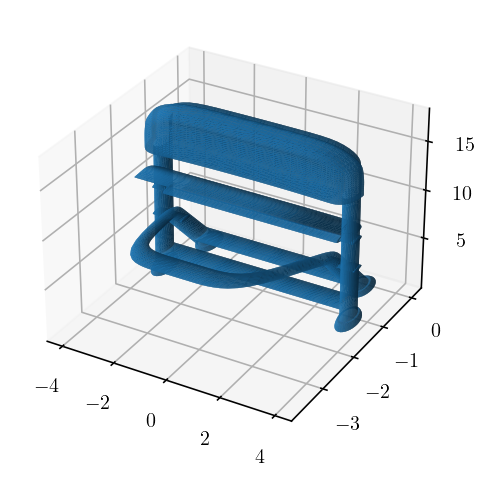

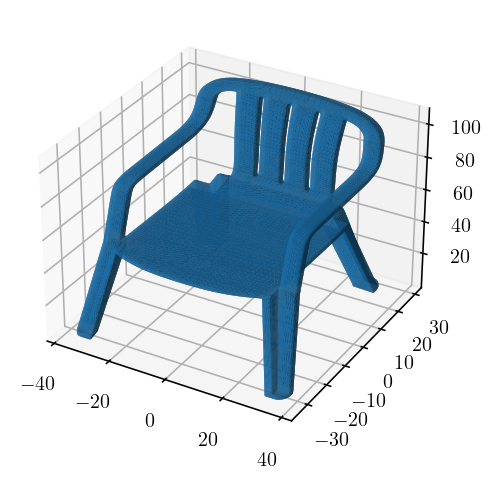

In [5]:
#Load the meshes
frog1 = trimesh.load('models/frog1.obj')
frog2 = trimesh.load('models/frog2.obj')
frog3 = trimesh.load('models/frog3.obj')
frog4 = trimesh.load('models/frog4.obj')
chair1 = trimesh.load('models/chair1.obj')
chair2 = trimesh.load('models/chair2.obj')
chair3 = trimesh.load('models/chair3.obj')
chair4 = trimesh.load('models/chair4.obj')
names = ["Torus 1","Torus 2","Torus 3","Torus 4","Frog 1 [F1]","Frog 2 [F2]","Frog 3 [F3]","Frog 4 [F4]","Chair 1 [C1]","Chair 2 [C2]","Chair 3 [C3]","Chair 4 [C4]"]
meshes = [frog1,frog2,frog3,frog4,chair1,chair2,chair3,chair4]

#Plot the meshes
for i in range(len(meshes)):

    mesh = meshes[i]
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    if i == 3:
        ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], mesh.vertices[:,2], triangles=mesh.faces)
        ax.view_init(elev=10,azim = 150)
    else:
        ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], mesh.vertices[:,2], triangles=mesh.faces)

    plt.show()
    plt.close()

Now, we can create point clouds corresponding to the meshes.

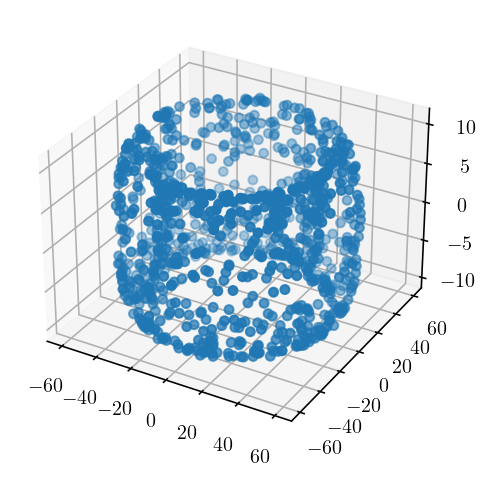

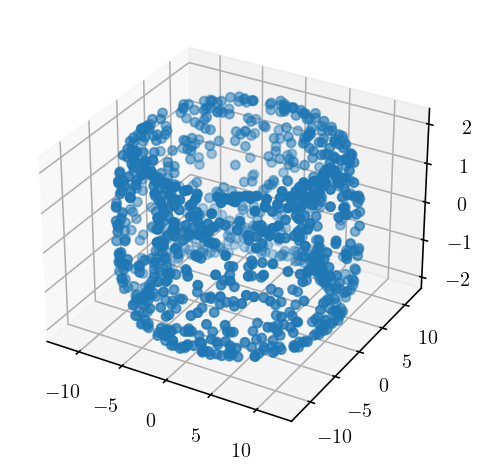

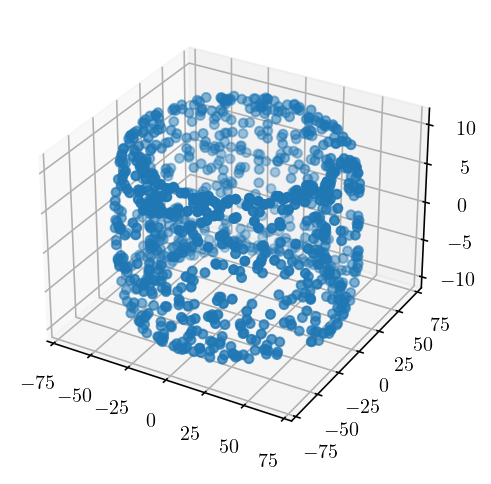

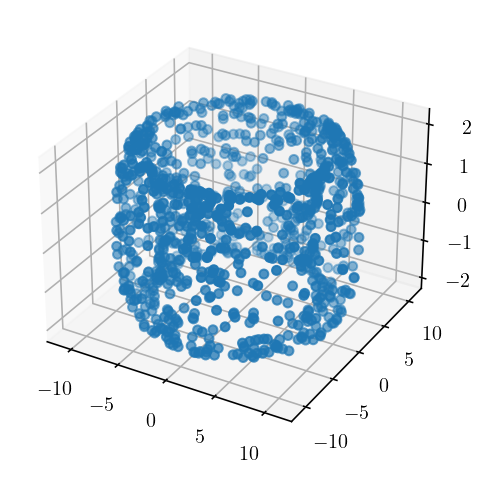

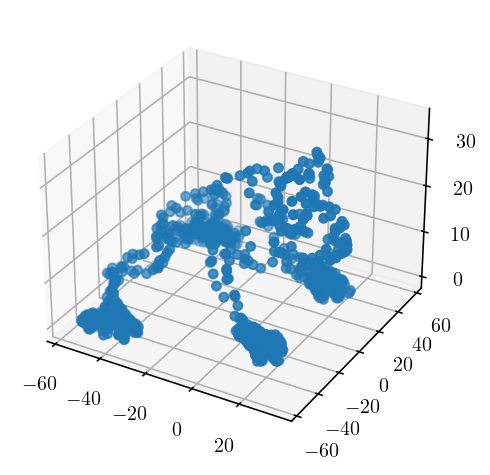

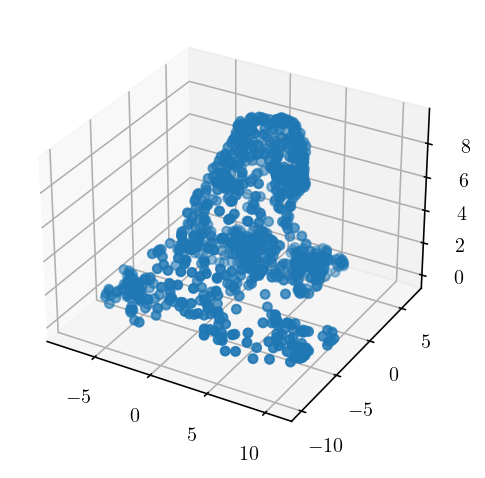

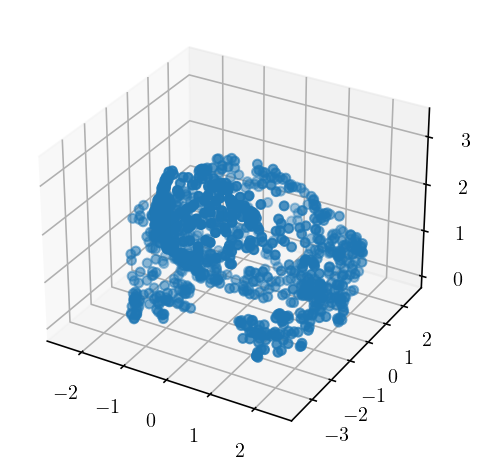

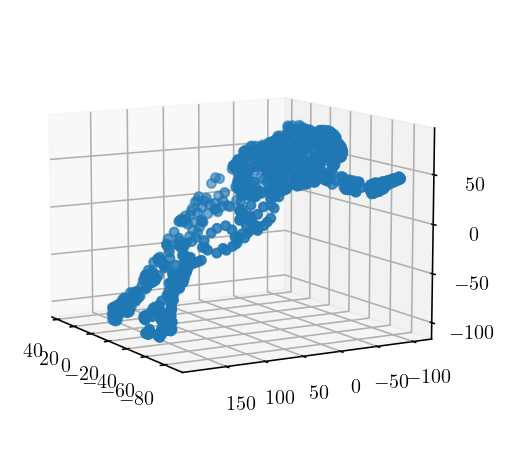

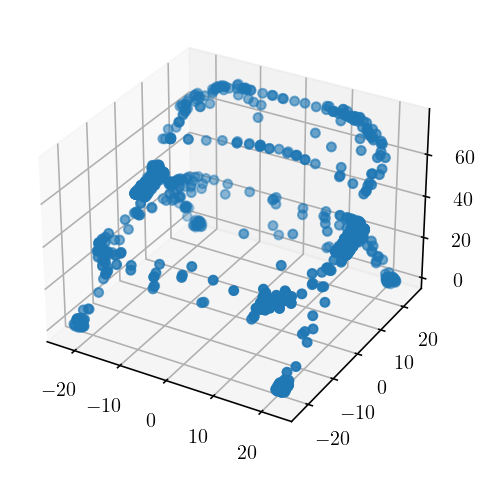

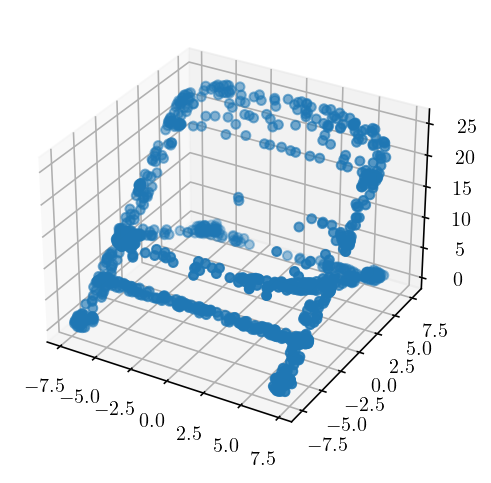

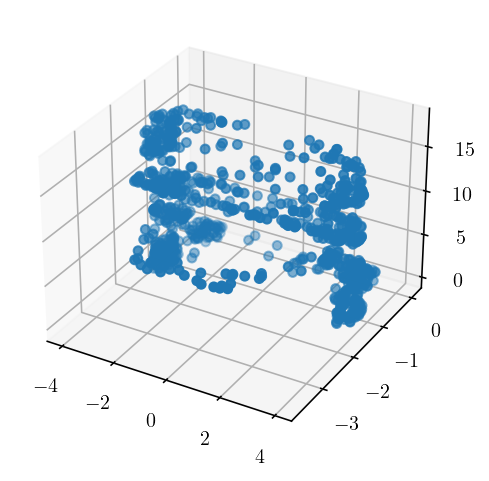

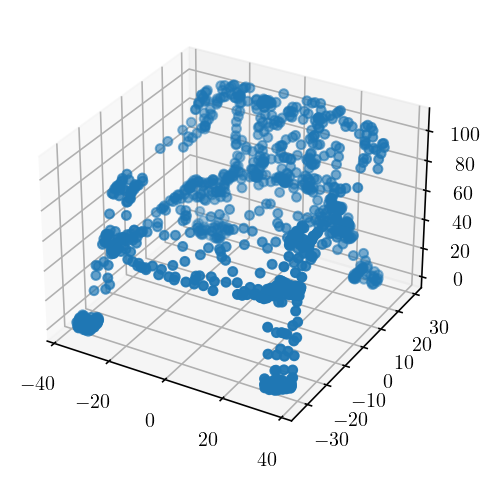

In [6]:
#Sample points from each of the vertex sets
numpoints = 1000
random.seed("oof")

torus1v = torus(r=10,R=50)
torus2v = torus(r=2,R=10)
torus3v = torus(r=10,R=60)
torus4v = torus(r=2,R=9)
frog1v = 10*np.array(random.sample(list(frog1.vertices), numpoints))
frog2v = np.array(random.sample(list(frog2.vertices), numpoints))
frog3v = np.array(random.sample(list(frog3.vertices), numpoints))
frog4v = 10*np.array(random.sample(list(frog4.vertices), numpoints))
chair1v = np.array(random.sample(list(chair1.vertices), numpoints))
chair2v = np.array(random.sample(list(chair2.vertices), numpoints))
chair3v = np.array(random.sample(list(chair3.vertices), numpoints))
chair4v = np.array(random.sample(list(chair4.vertices), numpoints))

#Plot each figure


#Torus1

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(torus1v[:, 0], torus1v[:,1], torus1v[:,2])
plt.show()
plt.close()

#Torus2

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(torus2v[:, 0], torus2v[:,1], torus2v[:,2])
plt.show()
plt.close()

#Torus3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(torus3v[:, 0], torus3v[:,1], torus3v[:,2])
plt.show()
plt.close()

#Torus4

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(torus4v[:, 0], torus4v[:,1], torus4v[:,2])
plt.show()
plt.close()

#frog1

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(frog1v[:, 0], frog1v[:,1], frog1v[:,2])
plt.show()
plt.close()

#frog2

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(frog2v[:, 0], frog2v[:,1], frog2v[:,2])
plt.show()
plt.close()

#frog3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(frog3v[:, 0], frog3v[:,1], frog3v[:,2])
plt.show()
plt.close()

#frog4

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(frog4v[:, 0], frog4v[:,1], frog4v[:,2])
ax.view_init(elev=10,azim = 150)
plt.show()
plt.close()

#chair1

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(chair1v[:, 0], chair1v[:,1], chair1v[:,2])
plt.show()
plt.close()

#chair2

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(chair2v[:, 0], chair2v[:,1], chair2v[:,2])
plt.show()
plt.close()

#chair3

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(chair3v[:, 0], chair3v[:,1], chair3v[:,2])
plt.show()
plt.close()

#chair4

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(chair4v[:, 0], chair4v[:,1], chair4v[:,2])
plt.show()
plt.close()

## Compute the distances ##
Now we can compute the bottleneck distances for the usual definition of bottleneck distance (this might take a bit of time to run).

In [7]:
#Find the usual bottleneck distances
dgm_torus1 = ripser.ripser(torus1v)['dgms'][1]
dgm_torus2 = ripser.ripser(torus2v)['dgms'][1]
dgm_torus3 = ripser.ripser(torus3v)['dgms'][1]
dgm_torus4 = ripser.ripser(torus4v)['dgms'][1]
dgm_frog1 = ripser.ripser(frog1v)['dgms'][1]
dgm_frog2 = ripser.ripser(frog2v)['dgms'][1]
dgm_frog3 = ripser.ripser(frog3v)['dgms'][1]
dgm_frog4 = ripser.ripser(frog4v)['dgms'][1]
dgm_chair1 = ripser.ripser(chair1v)['dgms'][1]
dgm_chair2 = ripser.ripser(chair2v)['dgms'][1]
dgm_chair3 = ripser.ripser(chair3v)['dgms'][1]
dgm_chair4 = ripser.ripser(chair4v)['dgms'][1]
dgms = [dgm_torus1,dgm_torus2,dgm_torus3,dgm_torus4,dgm_frog1,dgm_frog2,dgm_frog3,dgm_frog4,dgm_chair1,dgm_chair2,dgm_chair3,dgm_chair4]

#Get all pairwise distances
bottleneck_distances = np.zeros((12,12))
for i in range(11):
    for j in range(i+1,12):
        x = dgms[i]
        y = dgms[j]
        distance = persim.bottleneck(x, y)
        bottleneck_distances[i][j] = distance
        bottleneck_distances[j][i] = distance

For comparison, we can compute the normalized bottleneck distances (this might take a bit of time to run).

In [8]:
#Find the normalized bottleneck distances
dgm_torus1n = ripser.ripser(torus1v)['dgms'][1]/diameter(torus1v)
dgm_torus2n = ripser.ripser(torus2v)['dgms'][1]/diameter(torus2v)
dgm_torus3n = ripser.ripser(torus3v)['dgms'][1]/diameter(torus3v)
dgm_torus4n = ripser.ripser(torus4v)['dgms'][1]/diameter(torus4v)
dgm_frog1n = ripser.ripser(frog1v)['dgms'][1]/diameter(frog1v)
dgm_frog2n = ripser.ripser(frog2v)['dgms'][1]/diameter(frog2v)
dgm_frog3n = ripser.ripser(frog3v)['dgms'][1]/diameter(frog3v)
dgm_frog4n = ripser.ripser(frog4v)['dgms'][1]/diameter(frog4v)
dgm_chair1n = ripser.ripser(chair1v)['dgms'][1]/diameter(chair1v)
dgm_chair2n = ripser.ripser(chair2v)['dgms'][1]/diameter(chair2v)
dgm_chair3n = ripser.ripser(chair3v)['dgms'][1]/diameter(chair3v)
dgm_chair4n = ripser.ripser(chair4v)['dgms'][1]/diameter(chair4v)
dgmsn = [dgm_torus1n,dgm_torus2n,dgm_torus3n,dgm_torus4n,dgm_frog1n,dgm_frog2n,dgm_frog3n,dgm_frog4n,
         dgm_chair1n,dgm_chair2n,dgm_chair3n,dgm_chair4n]

nbottleneck_distances = np.zeros((12,12))
#Get all pairwise distances
for i in range(11):
    for j in range(i+1,12):
        x = dgmsn[i]
        y = dgmsn[j]
        distance = persim.bottleneck(x, y)
        nbottleneck_distances[i][j] = distance
        nbottleneck_distances[j][i] = distance

## Cluster ##
From these distances, we can now compute a 2-dimensional MDS embedding and apply kmeans clustering. 

In [9]:
#Cluster using KMeans
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

#Embed 
Xhat = MDS(n_components = 2, dissimilarity = 'precomputed').fit_transform(bottleneck_distances)
Xhatn = MDS(n_components = 2, dissimilarity = 'precomputed').fit_transform(nbottleneck_distances)
                        
#Cluster into 3 clusters
kmeans = KMeans(n_clusters= 3, random_state=0).fit(Xhat)
kmeansn = KMeans(n_clusters= 3, random_state=1).fit(Xhatn)


print(kmeans.labels_)
print(kmeansn.labels_)

/home/user/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

[2 0 1 0 0 0 0 0 0 0 0 0]
[1 1 1 1 0 0 0 0 2 2 2 2]


The ordinary bottleneck distance doesn't create clear clusters.

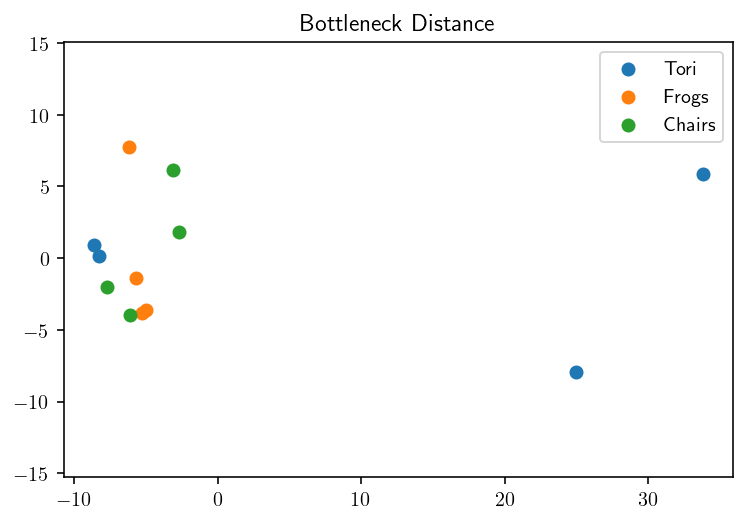

In [10]:
plt.title("Bottleneck Distance")
plt.scatter(Xhat[0:4,0], Xhat[0:4,1], label="Tori")
plt.scatter(Xhat[4:8,0], Xhat[4:8,1], label="Frogs")
plt.scatter(Xhat[8:12,0], Xhat[8:12,1], label="Chairs")
plt.axis('equal')
plt.legend()
plt.show()

The normalized bottleneck distance does far better.

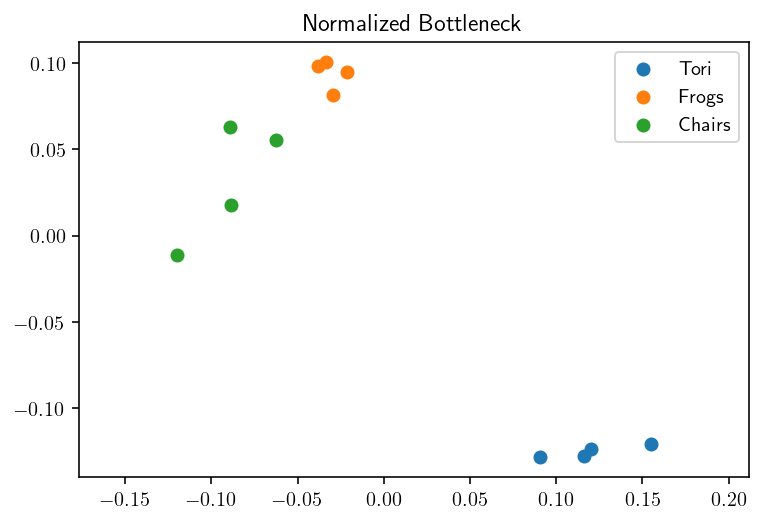

In [11]:
plt.title("Normalized Bottleneck")
plt.scatter(Xhatn[0:4,0], Xhatn[0:4,1], label="Tori")
plt.scatter(Xhatn[4:8,0], Xhatn[4:8,1], label="Frogs")
plt.scatter(Xhatn[8:12,0], Xhatn[8:12,1], label="Chairs")
plt.axis('equal')
plt.legend()
plt.show()